In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from nltk.util import ngrams 
import string
from collections import Counter
from itertools import chain 
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoLarsCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler  

In [3]:
df = pd.read_csv('AB_NYC_2019.csv')
df.drop(columns='reviews_per_month',inplace=True)
disp = pd.concat([df.isna().sum(),((df.isna().sum())/len(df))*100],axis=1)
disp.columns = ['# missing','frequency']
disp

,# missing,frequency
id,0,0.000000
name,16,0.032723
host_id,0,0.000000
host_name,21,0.042949
neighbourhood_group,0,0.000000
neighbourhood,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
room_type,0,0.000000
price,0,0.000000


In [13]:
df['last_review'] = df['last_review'].fillna(pd.Timestamp('20170101'))
df['last_review'] = pd.to_datetime(df['last_review'])
df['last_review']
df.name = df.name.fillna('Unknown')
df.host_name = df.host_name.fillna('Unknown')
#df.isna().sum()

In [14]:
df = df.assign(days_since_last_review = (pd.Timestamp('20200217') - df['last_review']))
df['days_since_last_review'] = df['days_since_last_review'].dt.days
df = df.drop('last_review', axis=1)
#df.head()

# Data cleaning and data transformation

In [15]:
tolist_rmv = [['bedroom','bdr','bdrm','br','bedrm','brd'],['bed','bd','b'],['bath','ba','bathroom','bth','bthrm','bathrm'],
             ['minute','min','mn'],['room','rm']]#all variations of the words bedroom,bed,bath and minute in the column 'names'
replacewith = ['bedroom','bed','bath','minute','room']
s = '|||'.join(df.name).lower()
filt = re.sub(r'([0-9])([a-z])', r'\1 \2', s)
filt = re.sub(r'([0-9])-([a-z])', r'\1 \2', filt)
filt = re.sub(r'one|single"', r'1', filt)
filt = re.sub(r'two|double"', r'2', filt)
filt = re.sub(r'three|triple"', r'3', filt)
filt = re.sub(r'/w', r'with', filt)
filt = re.sub(r'\-|\+|\—|/|\\',r' ',filt)
for i in range(len(tolist_rmv)):
    filt = re.sub(r'|'.join('\\b{0}\\b'.format(w) for w in tolist_rmv[i]),replacewith[i],filt)
    filt = re.sub(r'|'.join('\\b{0}\\b'.format(w+'s') for w in tolist_rmv[i]),replacewith[i],filt)
filt = filt.split('|||')
tmp = []

for i in range(0,len(filt)):
  tmp.append(nltk.word_tokenize(filt[i]))

stop_words = set(stopwords.words('english')) 

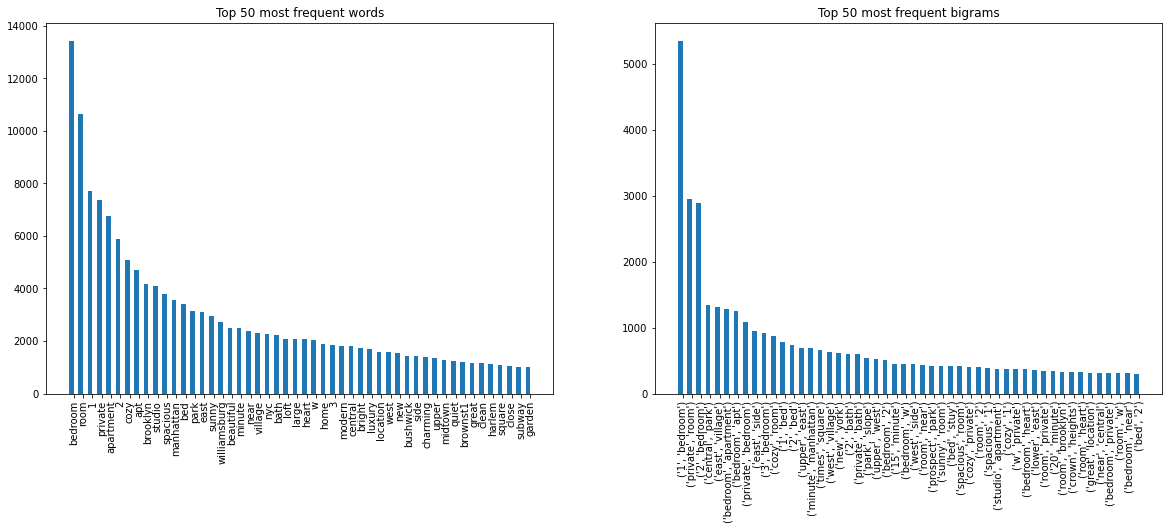

In [16]:
stop_words.update(string.punctuation)
filtered_sentence = [[w for w in tmp[x] if not w in stop_words] for x in range(0,len(tmp))]


words = list(chain.from_iterable(filtered_sentence))

w = Counter(words)
w.most_common()
labels, values = zip(*w.most_common(50))

indexes = np.arange(len(labels))
width = 0.5
fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
plt.title('Top 50 most frequent words')
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels,rotation=90)

n_gram = 2
x = Counter(ngrams(words, n_gram))
labels, values = zip(*x.most_common(50))
indexes = np.arange(len(labels))
width = 0.5
plt.subplot(2, 2, 2)
plt.title('Top 50 most frequent bigrams')
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels,rotation=90)

fig.set_figheight(15)
fig.set_figwidth(20)
plt.show()

In [17]:
df['filtered_sentence'] = filtered_sentence
df['bigram'] = df.filtered_sentence.apply(lambda row: list(ngrams(row, 2)))
#df = df.drop(columns='filtered_sentence')
df['bigram'][1]
xcommon = x.most_common(100)

In [18]:
#looking for the top 100 bigrams with numbers that might be relevant for the analysis
#increasing the number of ngrams from a 100 to 2000 will yield better results and more ngrams tho its computionaly expensive
tmp1 = [xcommon[i][0] for i in range(0,len(xcommon)) if any(map(lambda c:c.isdigit(), xcommon[i][0]))]
print(tmp1)
print("\n All unique words with no integers : ",set([tmp1[i][z] for i in range(len(tmp1)) for z in range(2) if not tmp1[i][z].isdigit()]))
print("\n\nLength of current list of bigrams with numerics : {}".format(len(tmp1)))

[('1', 'bedroom'), ('2', 'bedroom'), ('3', 'bedroom'), ('1', 'bed'), ('2', 'bed'), ('2', 'bath'), ('bedroom', '2'), ('15', 'minute'), ('room', '2'), ('spacious', '1'), ('cozy', '1'), ('20', 'minute'), ('bed', '2'), ('5', 'minute'), ('10', 'minute'), ('room', '1'), ('3', 'bed'), ('large', '1'), ('spacious', '2'), ('bedroom', '1'), ('4', 'bedroom'), ('sunny', '1')]

 All unique words with no integers :  {'minute', 'bed', 'cozy', 'bedroom', 'room', 'sunny', 'spacious', 'bath', 'large'}


Length of current list of bigrams with numerics : 22


In [19]:
#modify if statement in 'second' function with desired list variables to filter out from ngram list
def second(l):
    if l in ['bedroom','bed','bath','minute','apartment','room'] or l.isdigit() or len(l)<3:
        return(l)
    
bigrams_toadd = [xcommon[i][0] 
 for i in range(0,len(xcommon)) 
 if not any(map(second, xcommon[i][0]))]
bigrams_toadd = [(4,' '.join(i)) for i in bigrams_toadd]#preparing data for the extract_bigrams function
print(bigrams_toadd)
print("\n\nLength of current list of bigrams : {}".format(len(bigrams_toadd)))

[(4, 'central park'), (4, 'east village'), (4, 'east side'), (4, 'upper east'), (4, 'times square'), (4, 'west village'), (4, 'new york'), (4, 'park slope'), (4, 'upper west'), (4, 'west side'), (4, 'prospect park'), (4, 'cozy private'), (4, 'lower east'), (4, 'crown heights'), (4, 'great location'), (4, 'near central'), (4, 'cozy studio'), (4, 'clinton hill'), (4, 'newly renovated'), (4, 'brand new'), (4, 'heart williamsburg'), (4, 'home away'), (4, 'away home'), (4, 'sunny spacious'), (4, 'fort greene'), (4, 'midtown manhattan'), (4, 'best location'), (4, 'apt near'), (4, 'midtown east'), (4, 'time square'), (4, 'large private'), (4, 'spacious private'), (4, 'prime location'), (4, 'brooklyn brownst1'), (4, 'studio apt'), (4, 'greenwich village'), (4, 'near subway'), (4, 'studio heart')]


Length of current list of bigrams : 38


In [20]:
tokens_toadd = []#preparing tokens for function 

tmp = [w.most_common(100)[i][0] for i in range(0,len(w.most_common(100))) if not w.most_common(100)[i][0].isnumeric() 
       if not len(w.most_common(100)[i][0])<3 #removing short words with lenght less than 2
       if not w.most_common(100)[i][0] in ['bedroom','bed','bath','minute','apartment','room']] #list of words to drop

for i in range(0,len(tmp)):
    tokens_toadd.append((0,tmp[i]))
    
print(tokens_toadd)
print("\n\nLength of current list of tokens : {}".format(len(tmp)))

[(0, 'private'), (0, 'cozy'), (0, 'apt'), (0, 'brooklyn'), (0, 'studio'), (0, 'spacious'), (0, 'manhattan'), (0, 'park'), (0, 'east'), (0, 'sunny'), (0, 'williamsburg'), (0, 'beautiful'), (0, 'near'), (0, 'village'), (0, 'nyc'), (0, 'loft'), (0, 'large'), (0, 'heart'), (0, 'home'), (0, 'modern'), (0, 'central'), (0, 'bright'), (0, 'luxury'), (0, 'location'), (0, 'west'), (0, 'new'), (0, 'bushwick'), (0, 'side'), (0, 'charming'), (0, 'upper'), (0, 'midtown'), (0, 'quiet'), (0, 'brownst1'), (0, 'great'), (0, 'clean'), (0, 'harlem'), (0, 'square'), (0, 'close'), (0, 'subway'), (0, 'garden'), (0, 'huge'), (0, 'heights'), (0, 'times'), (0, 'duplex'), (0, 'prime'), (0, 'city'), (0, 'amazing'), (0, 'house'), (0, 'train'), (0, 'view'), (0, 'chelsea'), (0, 'suite'), (0, 'lovely'), (0, 'renovated'), (0, 'big'), (0, 'space'), (0, 'york'), (0, 'soho'), (0, 'astoria'), (0, 'best'), (0, 'floor'), (0, 'comfortable'), (0, 'comfy'), (0, 'hill'), (0, 'slope'), (0, 'gorgeous'), (0, 'entire'), (0, 'prospe

In [21]:
#convert to function:
#extract collocations
def extract_bigrams(column_name,option):
    if option == 0:
        ans = pd.DataFrame(np.zeros((len(df),1)))
        ans[column_name] = df['filtered_sentence'].apply(lambda x : [j for j in x if j in [column_name for i in x]]).apply(lambda x: 1 if len(x)!=0 else len(x))
        return(ans[column_name])
    if option == 1:
        dd = list(zip([str(i) for i in range(1,10) for _ in range(1,2)],[column_name]*9))
    if option == 2:
        dd = list(zip([str(i) for i in range(1,10) for _ in range(1,2)],[column_name]*9)) + list(zip([column_name]*9,[str(i) for i in range(1,10) for _ in range(1,2)]))
    if option == 3:
        dd = list(zip([str(i) for i in range(1,31) for _ in range(1,2)],[column_name]*30))
    if option == 4:
        ans = pd.DataFrame(np.zeros((len(df),1)))
        ans[column_name] = df['bigram'].apply(lambda x : [j for j in [column_name] if j in [' '.join(i) for i in x]]).apply(lambda x: 1 if len(x)!=0 else len(x))
        return(ans[column_name])        
    keep = []
    regex = re.compile("[-+]?[0-9]*\.?[0-9]+")#extracting integers from the columns in the new dataframe
    tolist = [' '.join(i) for i in dd]
    ans = pd.DataFrame(np.zeros((len(df),len(tolist))))

    for a in range(len(tolist)):
      ans[a] = df['bigram'].apply(lambda x : [j for j in [tolist[a]] if j in [' '.join(i) for i in x]]).apply(lambda x: 1 if len(x)!=0 else len(x)) 
      if a!=0:
        keep = keep + list(ans[a-1][ans[a-1]==1].reset_index()['index'])
        ds = ans.iloc[ans[a].iloc[keep][ans[a]==1].keys(),:][a].keys()#filtering out values so they don't appear twice in one row of the dataframe
        ans.iloc[ds,a]=0
    ans.columns = tolist
    integers = [int(regex.findall(x)[0]) if regex.findall(x) != []  else 1 for x in tolist]
    ans = ans * integers
    idx = [int(y) for y,x in enumerate(tolist) if regex.findall(x) != []]
    ans[column_name] = ans[ans.columns[idx]].sum(axis=1)
    ans = ans.drop(ans.columns[idx],axis=1)
    return(ans[column_name])

In [22]:
#0 to look for a tokenized word
#1,2,3 to look for bigrams followed by integers (perform a count)
#4 to look for bigrams with no integers

#tokens_toadd bigrams_toadd
for z,x in [(1,'bath'),(1,'room'),(2,'bedroom'),(1,'bed'),(3,'minute')] + bigrams_toadd + tokens_toadd:
    df[x] = extract_bigrams(x,z)
#df = df.drop(columns=['filtered_sentence','bigram'])

Percentage of 'bedroom' that are missing : 75.71%
Percentage of 'bedroom' in Entire/apt that are missing : 62.39%


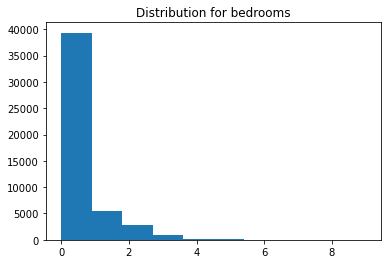

In [23]:
plt.hist(df.bedroom)
plt.title('Distribution for bedrooms')
print("Percentage of 'bedroom' that are missing : {}%".format(round((abs(len(df['bedroom'][df['bedroom']!=0])/len(df['bedroom'][df['bedroom']==0])-1)* 100),2)))
print("Percentage of 'bedroom' in Entire/apt that are missing : {}%".format(round(abs((len(df['bedroom'][df['bedroom']!=0])/len(df['bedroom'][df['room_type']=='Entire home/apt'])-1) * 100),2)))

In [24]:
df['name'][(df['room_type']=='Private room')&(df['bedroom']==3)]
# replacing all values for private room and shared rooms with 1 bedroom reasons the only values captured for 
#bedrooms are as follow '1 bedroom in 2 bedroom apartment' we can assume that there is only one bedroom
# in private room and shared room :

89                       Cozy Bedroom in Williamsburg 3 BR
148                       Cozy BR in Wiliamsburg 3 Bedroom
946                       Beautiful 3 bedroom in Manhattan
1441                Private rooms on a XLarge 3 br 2 baths
2037                   1 rm @ 3BR artist loft williamsburg
                               ...                        
48086    3 Bedroom Penthouse minutes from JFK and Manha...
48464           room in 3-bedroom house , Central Brooklyn
48715               Cozy bedroom - 3 Stops to Times Square
48718               Nice bedroom - 3 Stops to Times Square
48741       Sunny & spacious room in a 3 Br - Williamsburg
Name: name, Length: 166, dtype: object

In [25]:
#df['bedroom'][(df['room_type']=='Private room')] = 1
#df['bedroom'][(df['room_type']=='Shared room')] = 1
print("Percentage of 'bedroom' that are missing : {}%".format(round((abs(len(df['bedroom'][df['bedroom']!=0])/len(df['bedroom'][df['bedroom']==0])-1)* 100),2)))
print("Percentage of 'bedroom' in Entire/apt that are missing : {}%".format(round(abs((len(df['bedroom'][df['bedroom']!=0])/len(df['bedroom'][df['room_type']=='Entire home/apt'])-1) * 100),2)))

Percentage of 'bedroom' that are missing : 75.71%
Percentage of 'bedroom' in Entire/apt that are missing : 62.39%


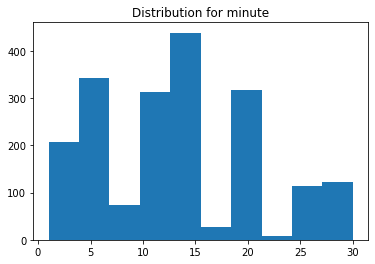

In [26]:
plt.hist(df.minute[df.minute!=0])
plt.title('Distribution for minute')
plt.show()

In [27]:
print(df['name'][df['bedroom']==5].to_string())

181                     Beautiful Queens Brownstone! - 5BR
1195                    Artist's Ditmas Pk 5 bedroom house
1527     LEGAL PARK SLOPE 5 BR, ROOF TERRACES for 14 PE...
2142                    5 Bdrm Historic Brownstone Triplex
3695                   NYC SuperBowl Wk 5 Bdrs River View 
4127                      Luxury 5BR Townhouse, Upper East
4581                     Cozy 5 Bdrm in Historic Harlem NY
5130                       Spacious 5 BR house in Brooklyn
5863                   5Bedroom Manhattan townhome triplex
6104                   Huge 5BR Townhouse - LEGAL NYC B&B!
6111     Amazing Single Bedroom Only 5min From Central ...
7253      5 Bedroom, 2 Bath, Steps to Train. FREE PARKING!
7386                   Large Duplex Near Subway! 5bdrm/2ba
8592                     Garden Commons Bushwick 5 Bedroom
8805                    UPPER EAST SIDE 5BR/4BA GARDEN APT
9090     BIG Beautiful private bedroom, 5 minutes to su...
9962         Cheerful Private Bedroom 5min to F & N Trai

In [28]:
tolist_rmv

[['bedroom', 'bdr', 'bdrm', 'br', 'bedrm', 'brd'],
 ['bed', 'bd', 'b'],
 ['bath', 'ba', 'bathroom', 'bth', 'bthrm', 'bathrm'],
 ['minute', 'min', 'mn'],
 ['room', 'rm']]

Number of room found in the dataset : 156


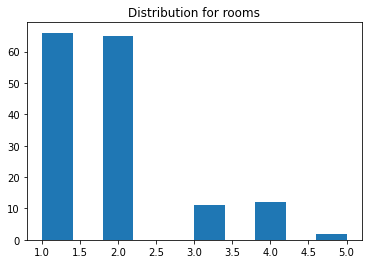

In [29]:
plt.hist(df.room[df.room!=0])
plt.title('Distribution for rooms')
print("Number of room found in the dataset : {}" .format(len(df.room[df.room!=0])))

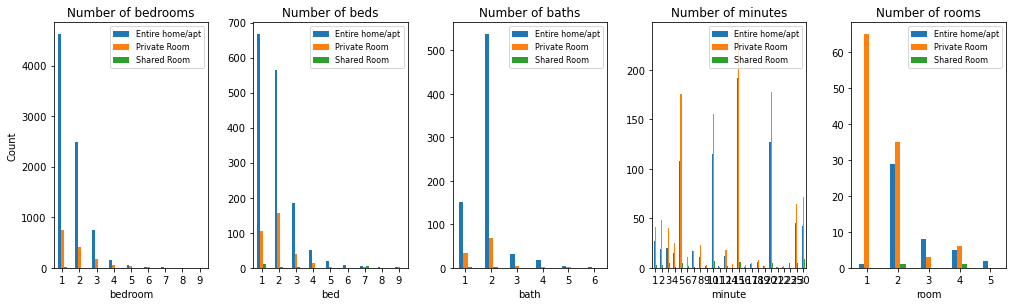

In [30]:
fig, axes = plt.subplots(figsize=(14, 4) , nrows = 1, ncols = len(replacewith))
fig.tight_layout()

#five categorical columns and three numerical columns of interest
for i, category in enumerate(replacewith):   
    ax = axes[i]
    df[df[category]!=0].groupby(['room_type',category])[['id']].count().rename(columns = {'id':'Number of '+category}).unstack(level=0).plot.bar(rot=0,ax=ax)
    ax.legend(["Entire home/apt", "Private Room","Shared Room"],prop={'size': 8})
    ax.title.set_text('Number of '+category+'s')
    ax.set_xlabel(category)
    axes[0].set_ylabel('Count')

Text(0, 0.5, 'price')

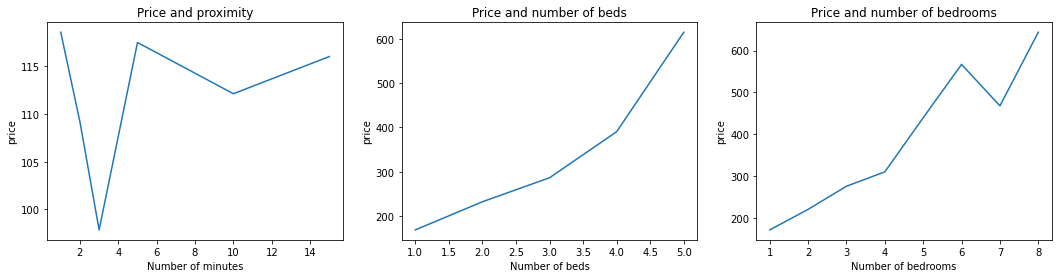

In [31]:
#to fix the price for the plots
fig, (ax, ax2, ax3) = plt.subplots(ncols=3,figsize=(18,4))
y = df[(df['minute']>=1)&(df['minute']<16)].groupby(['minute']).count()[['id']].rename(columns={'id':'Count'})
df[df.minute.isin(y[y.Count>60].index)].groupby(['minute']).mean()[['price']].plot(legend=None,ax=ax).title.set_text('Price and proximity')
ax.set_xlabel("Number of minutes")
ax.set_ylabel("price")
df[(df['bed']!=0)&(df['bed']<6)].groupby(['bed']).mean()[['price']].plot(legend=None,ax=ax2).title.set_text('Price and number of beds')
ax2.set_xlabel("Number of beds")
ax2.set_ylabel("price")
df[(df['bedroom']!=0)&(df['bedroom']!=9)].groupby(['bedroom']).mean()[['price']].plot(legend=None,ax=ax3).title.set_text('Price and number of bedrooms')
ax3.set_xlabel("Number of bedrooms")
ax3.set_ylabel("price")

In [32]:
df[df.minute.isin(y[y.Count>60].index)].groupby(['minute']).mean()[['price']]

,price
minute,
1,118.535211
2,109.157143
3,97.861538
5,117.463668
10,112.104693
15,115.993088


In [33]:
df.groupby("minute").filter(lambda x: len(x) < 210)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,balcony,artist,away,backyard,building,gym,uws,cute,doorman,shared
1010,409666,"1 bdr apt, sunny & artsy, 4 min walk to the beach",405225,Olga,Brooklyn,Brighton Beach,40.57810,-73.95455,Entire home/apt,75,...,0,0,0,0,0,0,0,0,0,0
1168,498859,"NYC 30 min by Subway, Brooklyn 2",2462260,Dimitry,Brooklyn,Brighton Beach,40.58220,-73.96392,Entire home/apt,169,...,0,0,0,0,0,0,0,0,0,0
1729,783964,GREAT ROOM Fast 2 TIMES SQ 9min NYC,2347382,Massi & Ray,Queens,Long Island City,40.74997,-73.93970,Private room,70,...,0,0,0,0,0,0,0,0,0,0
2286,1099244,Big UWS 1Bdrm 2 min to Central Park,5604089,Chris,Manhattan,Upper West Side,40.78264,-73.97803,Entire home/apt,200,...,0,0,0,0,0,0,1,0,0,0
2297,1107976,Manhattan & Time Square in 30 minutes. Back room.,3158364,Devika,Queens,Sunnyside,40.73600,-73.92425,Private room,35,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48796,36435986,1A. Studio & Stay. 30 minutes to Midtown Manha...,37678939,Chantal,Bronx,Concourse Village,40.83372,-73.91187,Private room,70,...,0,0,0,0,0,0,0,0,0,0
48809,36444734,Sunny Upper West Side Apt. 3mins from Central ...,32987938,Alex,Manhattan,Upper West Side,40.77889,-73.97668,Entire home/apt,143,...,0,0,0,0,0,0,0,0,0,0
48840,36452965,"❥❥NYC Apt: 4min/subway, 25m/city, 20m/LGA,JFK❥❥",63272360,Annie Lawrence,Queens,Woodhaven,40.69389,-73.86823,Entire home/apt,140,...,0,0,0,0,0,0,0,0,0,0
48843,36453642,"☆ HUGE, SUNLIT Room - 3 min walk from Train !",53966115,Nora,Brooklyn,Bedford-Stuyvesant,40.69635,-73.93743,Private room,45,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df[(df['bedroom'] == 2) & (df['room_type'] == 'Private room')]
print('Mean price for 2 bedrooms : ${0:.2f}'.format(round(df[(df['bedroom'] ==2)]['price'].mean(),2)))
print('Mean price between 5 and 8 bedrooms : ${0:.2f}'.format(round(df[(df['bedroom'] >= 5) & (df['bedroom'] <= 8)]['price'].mean(),2)))

Mean price for 2 bedrooms : $220.71
Mean price between 5 and 8 bedrooms : $475.06


In [35]:
output = df[(df['bedroom'] == 0) & (df['room_type'] == 'Entire home/apt')]['name'].to_string()

Visualizing correlations when the dataset has a lot of missing data (see above for number of bedrooms)
returns overall weaker correlations.

In [36]:
tex = df.dropna().drop(['id','host_id'],axis=1)
tex.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review,bath,room,...,balcony,artist,away,backyard,building,gym,uws,cute,doorman,shared
latitude,1.000000,0.084788,0.033939,0.024869,-0.015389,0.019517,-0.010983,0.032944,0.010962,-0.003701,...,0.000603,-0.030972,-0.002217,-0.031364,0.011490,0.018989,0.108782,0.000739,0.042048,0.000017
longitude,0.084788,1.000000,-0.150019,-0.062747,0.059094,-0.114713,0.082731,-0.102990,-0.021126,0.008065,...,-0.002018,-0.007222,0.059888,0.016312,-0.027457,-0.060740,-0.042857,-0.008675,-0.058424,0.010798
price,0.033939,-0.150019,1.000000,0.042799,-0.047954,0.057472,0.081829,0.058992,0.098404,-0.006055,...,0.003459,-0.001784,-0.013615,0.004347,0.009484,0.039937,0.018209,-0.017951,0.036097,-0.034522
minimum_nights,0.024869,-0.062747,0.042799,1.000000,-0.080116,0.127960,0.144303,0.096644,0.015571,0.000217,...,0.015228,-0.011019,-0.015014,-0.007836,0.012947,0.079938,0.006876,-0.002248,0.079134,0.013672
number_of_reviews,-0.015389,0.059094,-0.047954,-0.080116,1.000000,-0.072376,0.172028,-0.376004,-0.004879,-0.004773,...,-0.011407,0.008206,0.014628,-0.003165,-0.023165,-0.044301,-0.018660,-0.008090,-0.039430,-0.018798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gym,0.018989,-0.060740,0.039937,0.079938,-0.044301,0.388274,0.093345,0.053240,0.023661,-0.004893,...,0.050614,-0.009672,-0.009580,-0.009518,0.014643,1.000000,0.028425,-0.009330,0.408430,-0.009245
uws,0.108782,-0.042857,0.018209,0.006876,-0.018660,0.004792,-0.022077,0.040301,0.020789,-0.004850,...,0.009954,-0.009586,-0.005105,-0.002806,0.019367,0.028425,1.000000,0.008775,0.027052,-0.006890
cute,0.000739,-0.008675,-0.017951,-0.002248,-0.008090,-0.014272,-0.028642,0.012751,-0.011278,0.000705,...,0.001356,-0.000806,-0.002838,0.008360,-0.009371,-0.009330,0.008775,1.000000,-0.009153,0.006860
doorman,0.042048,-0.058424,0.036097,0.079134,-0.039430,0.261183,0.065438,0.054426,0.022908,-0.002946,...,0.060714,-0.009489,-0.009399,-0.009338,0.109195,0.408430,0.027052,-0.009153,1.000000,-0.009070


In [ ]:
#text_file = open("Output.txt", "w",encoding='utf-8')
#text_file.write("Purchase Amount: %s" % output)
#text_file.close()
corr = tex.corr()
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    corr, 
    vmin=-0.8, vmax=0.8, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Some Visualizations 

In [37]:
#creating new data frame with number of bedrooms/bath/room/bed
#encoding the price and slicing it in 3 
bins = df['price'].describe()[3:].tolist()
print(pd.cut(df['price'], bins).value_counts())
reduce = pd.concat([df[['bedroom','bath','room','bed']],pd.cut(df['price'], bins)],axis=1)
reduce.groupby(['price']).mean()

(0.0, 69.0]         12360
(106.0, 175.0]      12246
(175.0, 10000.0]    12177
(69.0, 106.0]       12101
Name: price, dtype: int64


,bedroom,bath,room,bed
price,,,,
"(0.0, 69.0]",0.103641,0.006230,0.005987,0.026537
"(69.0, 106.0]",0.192216,0.006528,0.009255,0.037270
"(106.0, 175.0]",0.349829,0.017312,0.003185,0.065001
"(175.0, 10000.0]",0.623470,0.101503,0.005092,0.153650


# Preparing data and Hyperparameter tuning

In [38]:
from scipy import stats
print('dropping columns : ',df.columns[[0,1,2,3,4,9,15,16]].values)
final_df = df.drop(columns = df.columns[[0,1,2,3,4,9,15,16]].values)
final_df = final_df.join(pd.get_dummies(df['neighbourhood'])).drop('neighbourhood',axis=1)
final_df = final_df.join(pd.get_dummies(df['room_type'])).drop('room_type',axis=1)

final_df['price'] = np.log1p(df.price)
final_df

dropping columns :  ['id' 'name' 'host_id' 'host_name' 'neighbourhood_group' 'price'
 'filtered_sentence' 'bigram']


,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review,bath,room,bedroom,...,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside,Entire home/apt,Private room,Shared room,price
0,40.64749,-73.97237,1,9,6,365,486,0,0,0,...,0,0,0,0,0,0,0,1,0,5.010635
1,40.75362,-73.98377,1,45,2,355,272,0,0,0,...,0,0,0,0,0,0,1,0,0,5.420535
2,40.80902,-73.94190,3,0,1,365,1142,0,0,0,...,0,0,0,0,0,0,0,1,0,5.017280
3,40.68514,-73.95976,1,270,1,194,227,0,0,0,...,0,0,0,0,0,0,1,0,0,4.499810
4,40.79851,-73.94399,10,9,1,0,455,0,0,0,...,0,0,0,0,0,0,1,0,0,4.394449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,2,0,2,9,1142,0,0,1,...,0,0,0,0,0,0,0,1,0,4.262680
48891,40.70184,-73.93317,4,0,2,36,1142,0,0,0,...,0,0,0,0,0,0,0,1,0,3.713572
48892,40.81475,-73.94867,10,0,1,27,1142,0,0,0,...,0,0,0,0,0,0,1,0,0,4.753590
48893,40.75751,-73.99112,1,0,6,2,1142,0,0,0,...,0,0,0,0,0,0,0,0,1,4.025352


In [39]:
#Grid searchCV
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=4, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            scores = abs(scores)
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [40]:
models1 = {
    'RandomForestRegressor': RandomForestRegressor(),
    'LassoRegression': linear_model.Lasso(max_iter=100000),
    'ElasticNet': linear_model.ElasticNet(),
    'HuberRegressor': linear_model.HuberRegressor()
}

params1 = {
    'RandomForestRegressor': { 'n_estimators': [200,30],'max_depth':[20,10]},
    'LassoRegression': { 'alpha': [1e-06,1e-05,0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1]},
    'ElasticNet': { 'alpha': [0.1, 0.4, 0.7]},
    'HuberRegressor': {'alpha': [1.2,1.35]}
}

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.iloc[:,:-1].values, final_df.iloc[:,-1].values.reshape(-1, 1), test_size=0.2, random_state=42)
#todo : randomized gridsearchCV 
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1)

Running GridSearchCV for RandomForestRegressor.
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 13.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for LassoRegression.
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for ElasticNet.
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.4s finished


Running GridSearchCV for HuberRegressor.
Fitting 4 folds for each of 2 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.1min finished


In [42]:
helper1.score_summary(sort_by='max_score')

RandomForestRegressor
LassoRegression
ElasticNet
HuberRegressor


,estimator,min_score,mean_score,max_score,std_score,max_depth,n_estimators,alpha
13,LassoRegression,0.461826,0.478453,0.49082,0.0114294,NaN,NaN,1
16,ElasticNet,0.461276,0.477655,0.489842,0.0112639,NaN,NaN,0.7
12,LassoRegression,0.461264,0.477625,0.489799,0.0112516,NaN,NaN,0.3
15,ElasticNet,0.449002,0.466391,0.479615,0.0117745,NaN,NaN,0.4
11,LassoRegression,0.31255,0.326586,0.336805,0.0102766,NaN,NaN,0.1
14,ElasticNet,0.287369,0.300439,0.310942,0.00982837,NaN,NaN,0.1
10,LassoRegression,0.277399,0.289512,0.299997,0.00965248,NaN,NaN,0.05
9,LassoRegression,0.248747,0.258381,0.269929,0.00920841,NaN,NaN,0.01
8,LassoRegression,0.236025,0.244206,0.256022,0.00857295,NaN,NaN,0.005
18,HuberRegressor,0.22273,0.229912,0.241365,0.00772413,NaN,NaN,1.35


In [52]:
from sklearn.model_selection import KFold

def mse_cv(model):
    kf = KFold(5, shuffle=True, random_state = 91).get_n_splits(final_df.iloc[:,:-1])
    mse= -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf)
    return(mse)
best_random = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
rfr_CV_best = mse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was pa

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.184079,0.006113,0.112256,0.172443,0.769049,0.635495


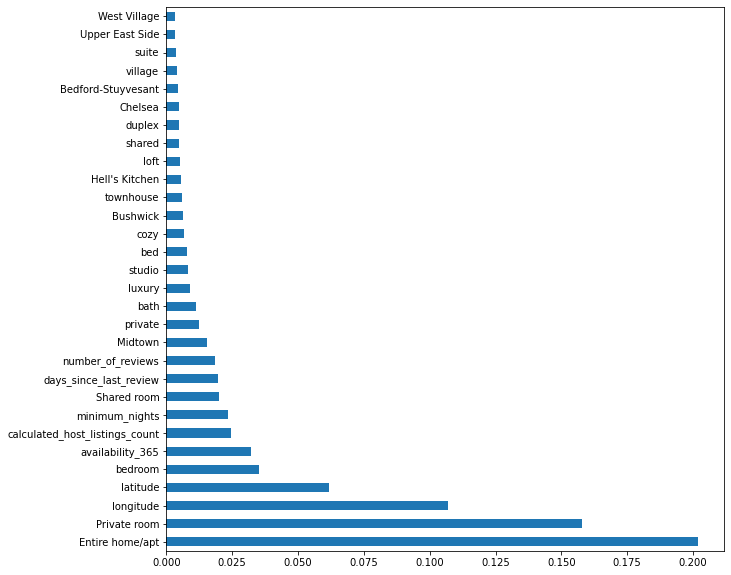

In [56]:
feat_importances = pd.Series(best_random.feature_importances_, index=final_df.columns[:-1])
feat_importances.nlargest(30).plot(figsize=(10,10),kind='barh')
plt.title('Feature Importance')
plt.show()